# scipy : Optimización

Inicialmente se importan los módulos de optimización y numpy

In [2]:
from scipy.optimize import minimize
import numpy as np

Existen multitud de métodos de optimización (minimización/maximización). El módulo optimize implementa algunos de estos métodos, los cuales se invocan todos a través de la función minimize, pero pueden variar los parámetros según 
el método de integración.

## Parábola en $R^2$ transladada

In [3]:
# Algunas constantes
a=1
b=2

# La función a optimizar
def parabola(x):
    return (x[0]-a)**2+(x[1]-b)**2

# Un punto inicial para arrancar el proceso
x0 = np.array([0.,0.])

# Minimización por el método 'nelder-mead'
results = minimize(parabola, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 97
         Function evaluations: 185


In [4]:
results

 final_simplex: (array([[ 1.        ,  2.        ],
       [ 1.        ,  2.        ],
       [ 1.00000001,  2.        ]]), array([  1.68165610e-17,   2.00725924e-17,   7.12162476e-17]))
           fun: 1.6816560972691699e-17
       message: 'Optimization terminated successfully.'
          nfev: 185
           nit: 97
        status: 0
       success: True
             x: array([ 1.,  2.])

In [5]:
# Ok, pero solo queremos el punto solución
results.x

array([ 1.,  2.])

## Generalización parábola en $R^n$

In [6]:
# Translacion
xt = np.array([ 1.,2.,3.,4.,5. ])

# La función a optimizar
def parabolaN(x):
    return ((x-xt)**2).sum()


Se define un punto inicial y se invoca la función de minización

In [7]:
# Un punto inicial para arrancar el proceso
x0 = np.zeros( 5 )

# Minimización por el método 'nelder-mead'
results = minimize(parabolaN, x0, method='nelder-mead', options={'xtol': 1e-6, 'disp': True})

In [8]:
results.x

array([ 0.99921734,  1.99994041,  3.00095397,  3.99974395,  5.00102968])

El disponer de las derivadas de la función objetivo abre la posibilidad de usar métodos que convergen más rápidamente.
Por ejemplo el gradiente (o jacobiano) de la parábola en $R^n$ está dado por la función:

In [9]:
# Calcular el jacobiano, matrix Nx1 de primeras derivadas de la función
def jacobian(x):
    return 2*(x-xt)

y el método Broyden-Fletcher-Goldfarb-Shanno (BFGS) puede hacer uso de las derivadas así:

In [10]:
# Minimización por el método 'BFGS', pasando la funcion del jacobiano
results = minimize(parabolaN, x0, method='BFGS', jac=jacobian, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4


In [11]:
results.x

array([ 1.,  2.,  3.,  4.,  5.])

Incluso, si se dispone de las segundas derivadas (Hessian) se pueden utilizar métodos aún más eficientes como el Newton-Conjugate-Gradient

In [12]:
# Calcular el Hessiano, matrix nxn de segundas derivadas de la función
def hessian(x):
    return np.diag( 2*np.ones(x.shape) )

# Minimización por el método 'Newton-CG', pasando la funcion del jacobiano y el hessiano
results = minimize(parabolaN, x0, method='Newton-CG', jac=jacobian, hess=hessian, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 4
         Hessian evaluations: 2


In [13]:
results.x

array([ 1.,  2.,  3.,  4.,  5.])

## Ajuste de curvas por mínimos cuadrados

El método de mínimos cuadrados se utiliza comunmente para determinar los parámetros de un modelo que mejor se ajustan a un conjunto de observaciones experimentales.

Supongamos que se tiene el siguiente conjunto de observaciones:

In [14]:
obs = np.array([ 2.52483651,  2.31425344,  2.6848971 ,  2.70174083,  3.0463613 ,
        2.99765209,  3.44428727,  3.5561104 ,  3.90656829,  4.04416544,
        4.42440144,  4.84459361,  4.79804493,  4.84273557,  5.08542649,
        5.0700754 ,  4.79993924,  4.82872352,  4.75390864,  4.25474467,
        4.42672152,  4.02190748,  3.91485327,  3.43295015,  3.43173336,
        2.92309118,  3.10279758,  2.82707051,  2.23905861,  2.29927556,
        2.46353113,  2.09561343,  2.22926611,  2.03924848,  1.96606807,
        1.9339189 ,  2.03639402,  2.10496801,  2.01822495,  2.10666009,
        2.13145425,  2.10118512,  1.95166921,  1.7079767 ,  2.05553464,
        1.83273161,  1.88716236,  1.8912594 ,  2.07873222,  1.96578077])

que corresponden a 50 puntos en el tiempo entre 0 y 5:

In [15]:
t = np.linspace(0, 5, 50)            # 50 evenly spaced samples

La gráfica de las observaciones es:

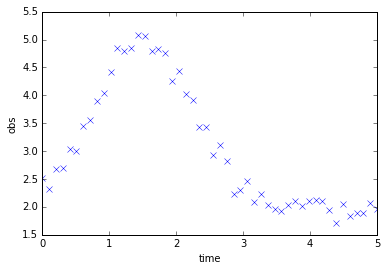

In [17]:
import matplotlib.pyplot as plt
plt.plot(t, obs, 'xb')
plt.xlabel('time')
plt.ylabel('obs')
plt.show()

y que el modelo que describe el fenómeno es de la forma:
$$ y(t) = A + B \exp{ \left\{ - \left( \frac{t-\mu}{\sigma} \right)^2 \right\}  }$$
donde A,B,$\mu$,$\sigma$ son los parámetros del modelo y $t$ es la variable independiente.
Sea coeff[] el vector de parámetros del modelo. Entonces, la función que describe el modelo es:

In [18]:
def modelo(t, coeffs):
    return coeffs[0]+coeffs[1]*np.exp(-((t-coeffs[2])/coeffs[3])**2)

El error residual es la diferencia entre las observaciones y el valor que predice el modelo. El método de mínimos cuadrados busca minimizar la suma de los cuadrados del error residual para todas las observaciones.
Por lo tanto debemos definir una función que determine el error residual:

In [19]:
def residuals(coeffs,obs,t):
    return obs-modelo(t,coeffs)

Y con el modelo, las observaciones y el error residual podemos encontrar los coeficientes del modelo que minimizan el error cuadrático:

In [20]:
# Se utiliza la funcion de minimos cuadrados del modulo scipy
from scipy.optimize import leastsq

# Se define un punto de partida para el proceso de minimización
x0 = np.ones(4)

# Se invoca el algoritmo de ajuste por mínimos cuadrados
x, flag = leastsq(residuals, x0, args=(obs, t))
x

array([ 1.97296506,  3.02661946,  1.50780691,  1.03453715])

Conocidos los coeficientes se puede evaluar el modelo $y(t)$ y hacer la gráfica de las observaciones vs el modelo ajustado

In [21]:
y = modelo(t, x)

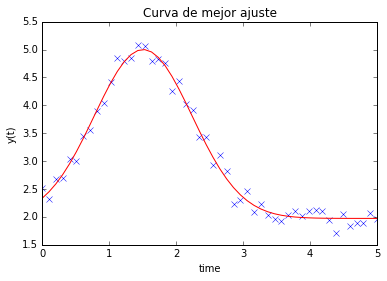

In [22]:
plt.plot(t, obs, 'xb', t, y, '-r')
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('Curva de mejor ajuste')
plt.show()

## Referencias

Módulo optimize de scipy
https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

Ajuste de curvas por el método de mínimos cuadrados
http://www.scipy-lectures.org/intro/summary-exercises/optimize-fit.html
